In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import sympy as sym
import warnings
import pickle as plk
from IPython.display import display, Math
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks

import os
import imp
import sys
import importlib.util

###############################################################
# LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/home/trainner/Documentos/Caio/GitReps/Photonics-training/Projects/Bragg Grating/SimulationFiles')) #Current directory

###############################################################
# WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Bragg Grating/SimulationFiles/'))
spec_win.loader.exec_module(lumapi)

## Lumapi inits

### Unfiltered FDTD

In [2]:
bragg = lumapi.FDTD(filename='BRAGGProjectFDTD.fsp',hide=False) 

### Filtered FDTD

In [2]:
bragg = lumapi.FDTD(filename='BRAGGLithography.fsp',hide=False) 

## Functions

In [3]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


# Format a function/dataset as a polygon
def PolyForm(x,y,ybase):
    y2 = y + ybase
    A = np.zeros((2,len(x)+2))
    
    A[0][1:len(x)+1] = x
    A[1][1:len(x)+1] = y2
    A[0][0] = x[0]
    A[0][len(x)+1] = x[-1]
    A[1][0] = ybase
    A[1][len(x)+1] = ybase
    
    return A

## Assembly parameters

In [4]:
zband = 25e-9               # Zeroes bandwidth
lmbd = 1500e-9              # Bragg Wavelength

neff = 2.345                # Effective index (450nm)
ng = 4.454                  # Group index (450nm)

#neff = 2.579              # Effective index (600nm)
#ng = 4.092                # Group index (600nm)

SilH = 450e-9 # Silicon height
SilW = 220e-9 # Silicon width
GlassH = 1e-6 # SiO2 height

L = 25e-6                   # Placeholder value

kappa = np.sqrt( (zband*np.pi*ng/(lmbd**2))**2  - (np.pi/L)**2 )
Rmax = (np.tanh(kappa*L))**2
delN = kappa*lmbd/2         # deltaNeff (For stepwise neff)

#Vh = (delN + 1.478e-3)/4.847e6  # DeltaW (Corrugation width) (450nm)
#Vh = (delN + 3.82e-4)/1.969e6  # DeltaW (Corrugation width) (600nm)

#Vp = lmbd/(2*neff)       # Grating period

# Direct setting
Vh = 35e-9        
Vp = 0.321e-6 

VpNum = int(L/Vp)

display(Math('\kappa = %5.2f,~~~~~ \Delta W = %5.2f nm,~~~~~ L = %5.2f um,~~~~~ R_{max} = %5.2f' %(kappa,Vh*1e9,L*1e6,Rmax)))
display(Math('\Lambda = %5.3fum,~~~~~ N = %5.0f,~~~~~ \Delta n = %3.5f,~~~~~ \kappa L = %3.5f' %(Vp*1e6,VpNum,delN, kappa*L)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Assembly main model

In [6]:
bragg.switchtolayout()
bragg.deleteall()

# Substract insert
RectInsert(VpNum*Vp/2, VpNum*Vp+1e-6, 0, GlassH*2, -(SilW+GlassH)/2, GlassH, "SiO2 (Glass) - Palik", bragg)
bragg.set("name", "Substract")

# Extremities insert
RectInsert(-0.25e-6, 0.5e-6, 0, SilH, 0, SilW, "Si (Silicon) - Palik", bragg)
bragg.set("name", "W1")
RectInsert(VpNum*Vp+0.25e-6, 0.5e-6, 0, SilH, 0, SilW, "Si (Silicon) - Palik", bragg)
bragg.set("name", "W2")

# Corrugation insert
bragg.addstructuregroup()
bragg.set("name","Corrugation")
for i in range(VpNum):
    RectInsert(Vp/4 + i*Vp, Vp/2, 0, SilH+Vh, 0, SilW, "Si (Silicon) - Palik", bragg)
    bragg.set("name", "Teeth+ " + str(i))
    bragg.addtogroup("Corrugation")
    RectInsert(0.75*Vp + i*Vp, Vp/2, 0, SilH-Vh, 0, SilW, "Si (Silicon) - Palik", bragg)
    bragg.set("name", "Teeth- " + str(i))
    bragg.addtogroup("Corrugation")

# FDTD setting
bragg.addfdtd()

bragg.set({"x":VpNum*Vp/2, "x span":VpNum*Vp+1e-6, "y":0, "y span":(SilH+2*Vh)*2.5, "z":0, "z span":1.5e-6,
           "mesh accuracy":7, "simulation time":15000e-15,
           "y min bc":"Anti-Symmetric", "y max bc":"PML", "z min bc":"PML", "z max bc":"PML"})


# Mesh insert
bragg.addmesh()
bragg.set({"x":VpNum*Vp/2, "x span":VpNum*Vp+1e-6, "y":0, "y span":SilH+Vh, "z":0, "z span":1.5*SilW})
bragg.set("set maximum mesh step",1)
bragg.set({"dx":0.05e-6,"dy":0.005e-6,"dz":0.05e-6})

# Ports setting
bragg.addport()
bragg.set({"x":-0.25e-6, "y span":(SilH+2*Vh)*5, "z span":3e-6,
           "direction":"Forward"})

bragg.addport()
bragg.set({"x":VpNum*Vp+0.25e-6,
           "direction":"Backward"})

bragg.select('FDTD::ports')
bragg.set('monitor frequency points',1000)

bragg.setglobalsource("wavelength start", lmbd-50e-9)
bragg.setglobalsource("wavelength stop", lmbd+50e-9)

# Monitor insert
bragg.addpower()
bragg.set({"x":VpNum*Vp/2, "x span":VpNum*Vp+1e-6, "y":0, "y span":(SilH+2*Vh)*2})
bragg.setglobalmonitor("use source limits",0)
bragg.setglobalmonitor("minimum wavelength",lmbd-50e-9)
bragg.setglobalmonitor("maximum wavelength",lmbd+50e-9)
bragg.setglobalmonitor("frequency points",1000)

# Reflection Monitor insert
bragg.addpower()
bragg.set({"name":"Reflection monitor", "monitor type":"2D X-normal",
           "x":-0.35e-6, "y":0, "y span":(SilH+2*Vh)*2, "z":0, "z span":(SilH+2*Vh)*2})
bragg.setglobalmonitor("use source limits",0)
bragg.setglobalmonitor("minimum wavelength",lmbd-50e-9)
bragg.setglobalmonitor("maximum wavelength",lmbd+50e-9)
bragg.setglobalmonitor("frequency points",300)

1.0

## Save data

dict_keys(['lambda', 'f', 'T', 'Lumerical_dataset'])


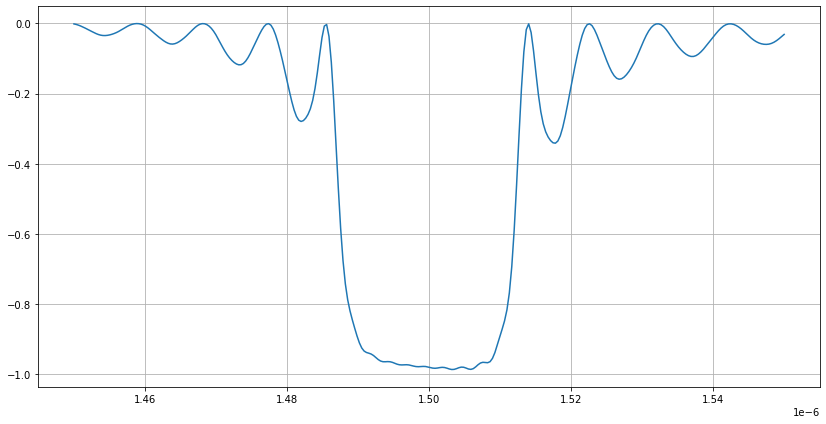

In [5]:
dataname = 'BraggReflection'
datapath = 'SavedData'

dataset = bragg.getresult("Reflection monitor","T");
print(dataset.keys())

xdata = dataset['lambda']
ydata = dataset['T']
plt.figure(figsize=(14, 7))
plt.plot(xdata,ydata)
plt.grid(True)

plotdata = [0,0]
plotdata[0] = xdata
plotdata[1] = ydata

completeName = os.path.join("SavedData/", str(dataname) + ' Data')
MSOutfile = open(completeName,'wb')
plk.dump(plotdata,MSOutfile)
MSOutfile.close()

## Load data

In [6]:
loadFiles = ['FilteredBraggReflection','BraggReflection']

loadPath = "SavedData/"
file_count = sum(len(files) for _, _, files in os.walk(loadPath))
data = {}
print('files found in datapath: '+str(file_count))

for i in range(len(loadFiles)):
    infile = open(os.path.join(loadPath, loadFiles[i]+' Data') , 'rb')
    data[loadFiles[i]] = plk.load(infile)
    infile.close()
    
#print(data)
dataFrame = pd.DataFrame(data)
dataFrame

files found in datapath: 6


,FilteredBraggReflection,BraggReflection
0,"[[1.55e-06], [1.5496425688919636e-06], [1.5492...","[[1.55e-06], [1.5496425688919636e-06], [1.5492..."
1,"[-0.03242079925693751, -0.033064960416072056, ...","[-0.031245312381911243, -0.03747924723685773, ..."


### Load parallel

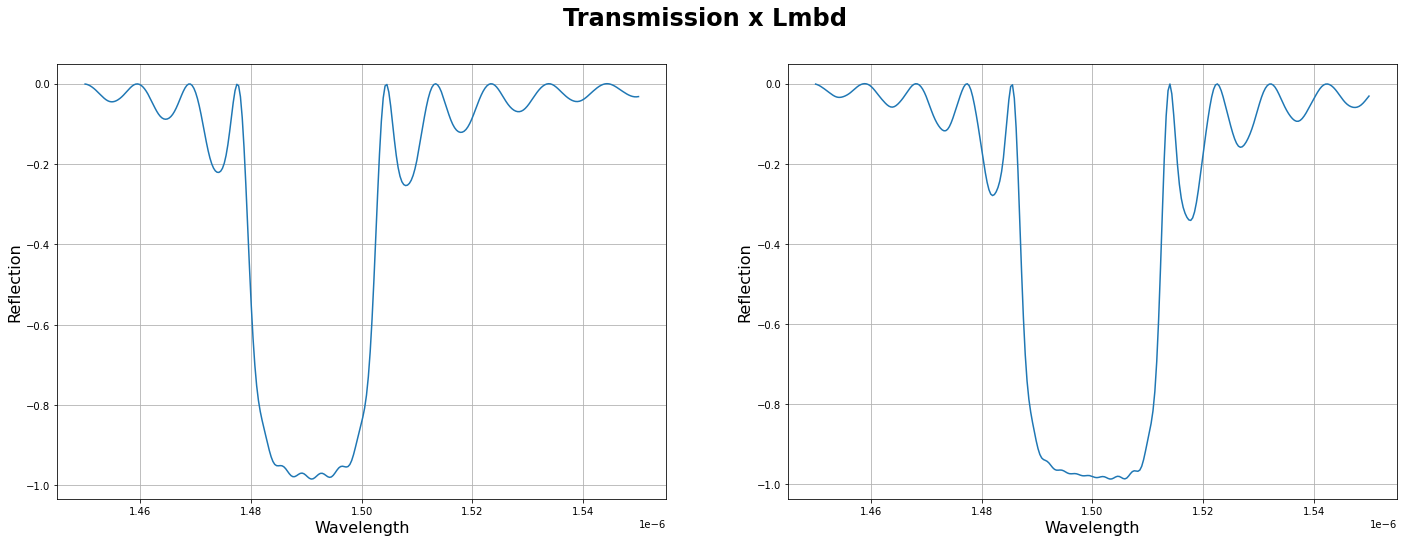

In [7]:
keyNames = list(data.keys())

winNum = int(1 + np.floor((len(keyNames) - 1)/2))  # Window line quantity
figure,ax=plt.subplots(winNum, 2, figsize=(24,winNum*8))
figure.suptitle('Transmission x Lmbd',fontsize=24, fontweight="bold")


for i in range(len(keyNames)):
    index = int(i%2)
    ax[index].grid(True)
    ax[index].plot(data[keyNames[i]][0],data[keyNames[i]][1])
    ax[index].set_xlabel("Wavelength",fontsize=16)
    ax[index].set_ylabel("Reflection",fontsize=16)

### Load in-one

FilteredBraggReflection: 22.166369569051085 nm
BraggReflection: 24.773037651795903 nm


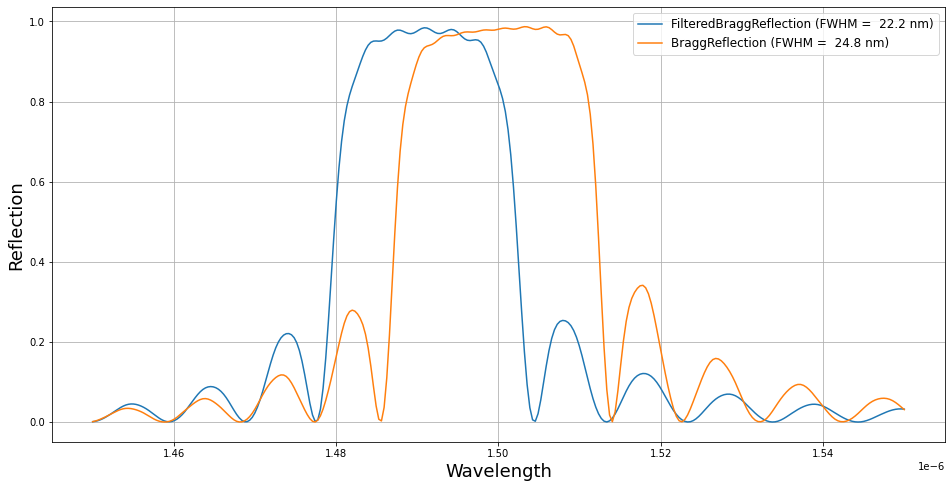

In [58]:
from matplotlib.pyplot import legend


keyNames = list(data.keys())

plt.figure(figsize=(16,8))
plt.xlabel("Wavelength",fontsize=18)
plt.ylabel("Reflection",fontsize=18)
plt.grid(True)

fwhm_i = np.zeros(len(keyNames))

for i in range(len(keyNames)):

    pnts = signalLv(-data[keyNames[i]][1],0.5,"linear")
    xaxis = data[keyNames[i]][0]
    xcoords = pnts['index']
    average = pnts['yMed']

    fwhm_i[i] = xaxis[xcoords[0]]*1e9 - xaxis[xcoords[1]]*1e9
    print(str(keyNames[i]) + ": " + str(fwhm_i[i]) + " nm")

    plt.plot(data[keyNames[i]][0],-data[keyNames[i]][1], label="{} (FWHM = {:5.1f} nm)".format(keyNames[i],fwhm_i[i]))
    plt.legend(fontsize=12)